## 11/13 Notebook to be converted to a script to run tests of mpasregions package
### This notebook is used to test the transect sorting algorithms. This requires consideration for transects created from algorithms and for transects created form an initial geojson mask file. 


for a periodic boundary, if you need to go across an entire latitude, the sorting algorithm shoudl divide the transect into upper and lower

In [360]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [361]:
#Packages 
import numpy as np
import xarray as xr
import cmocean.cm as cmo
import matplotlib.pyplot as plt
import mpas_tools

from geometric_features import GeometricFeatures
from geometric_features import read_feature_collection

from mpas_tools.mesh.mask import compute_mpas_region_masks
from mpas_tools.parallel import create_pool
from mpas_tools.io import write_netcdf

import geojson
import json
import mosaic
import os.path
import mpasregions.sections as mps
import gsw
import warnings 
import glob
from xgcm import Grid

### create dataset

In [362]:
# I actually think that you will need to somehow define cells to be nans to represent land (or at least for cellsOnEdge)... 
# And then you remove the edges and vertices that would be captured within those cells...? 

lonCells = np.array([180.,  90., 270.])
latCells = np.array([-36.,  36.,  36.])

lonEdges = np.array([135., 235.,  90., 270.,  45., 135., 225., 315.,   0., 180., 45., 135., 225., 315.])
latEdges = np.array([-72., -72., -36., -36.,   0.,   0.,   0.,   0.,  36.,  36., 72.,  72.,  72.,  72.])

lonVertices = np.array([180.,  90., 270.,  90., 270.,   0., 180.,   0., 180., 90., 270.])
latVertices = np.array([-90., -54., -54., -18., -18.,  18.,  18.,  54.,  54., 90.,  90.])

ds = xr.Dataset({},coords={
    'nCells':xr.DataArray(np.arange(0,len(lonCells)), dims='nCells'),
    'nEdges': xr.DataArray(np.arange(0,len(lonEdges)), dims='nEdges'),
    'nVertices':xr.DataArray(np.arange(0,len(lonVertices)), dims='nVertices')
})

ds['lonCell'] = xr.DataArray(np.deg2rad(lonCells), dims='nCells')
ds['latCell'] = xr.DataArray(np.deg2rad(latCells), dims='nCells')
ds['lonEdge'] = xr.DataArray(np.deg2rad(lonEdges), dims='nEdges')
ds['latEdge'] = xr.DataArray(np.deg2rad(latEdges), dims='nEdges')
ds['lonVertex'] = xr.DataArray(np.deg2rad(lonVertices), dims='nVertices')
ds['latVertex'] = xr.DataArray(np.deg2rad(latVertices), dims='nVertices')

xr_edgesOnVertex =  np.array([
    [0,1,np.nan], # on vertex 0
    [0,2,np.nan], # on vertex 1
    [1,3,np.nan], # on vertex 2
    [2,4,5], # on vertex 3
    [3,6,7], # on vertex 4
    [4,7,8], # on vertex 5
    [5,6,9], # on vertex 6
    [8,10,13], # on vertex 7
    [9,11,12], # on vertex 8
    [10,11,np.nan], # on vertex 9
    [12,13,np.nan] # on vertex 10
])

n_edgesOnVertex = mps.xr_to_n_idx(xr_edgesOnVertex)
n_edgesOnVertex[np.isnan(n_edgesOnVertex)] = 0 # extra vertices that were once nans are now zeros

ds['edgesOnVertex'] = xr.DataArray(np.int32(n_edgesOnVertex), dims = ('nVertices','vertexDegree'))
# ds['edgesOnVertex'] = ds.edgesOnVertex.where(ds.edgesOnVertex > 0)
# ds.edgesOnVertex

xr_verticesOnEdge = np.array([
    [0,1], # on edge 0
    [0,2], # on edge 1
    [1,3], # on edge 2
    [2,4], # on edge 3
    [3,5], # on edge 4
    [3,6], # on edge 5
    [4,6], # on edge 6
    [4,5], # on edge 7
    [5,7], # on edge 8
    [6,8], # on edge 9
    [7,9], # on edge 10
    [8,9], # on edge 11
    [8,10], # on edge 12
    [7,10] # on edge 13
    
])

n_verticesOnEdge = mps.xr_to_n_idx(xr_verticesOnEdge)
ds['verticesOnEdge'] = xr.DataArray(np.int32(n_verticesOnEdge), dims=('nEdges', 'TWO'))

xr_cellsOnEdge = np.array([
    [0,np.nan], # on edge 0
    [0,np.nan], # on edge 1
    [0,np.nan], # on edge 2
    [0,np.nan], # on edge 3
    [1,np.nan], # on edge 4
    [0,1],  # on edge 5
    [0,2],  # on edge 6
    [2,np.nan], # on edge 7
    [1,2],  # on edge 8
    [1,2],  # on edge 9
    [1,np.nan], # on edge 10
    [1,np.nan], # on edge 11
    [2,np.nan], # on edge 12
    [2,np.nan] #on edge 13
])

n_cellsOnEdge = mps.xr_to_n_idx(xr_cellsOnEdge)
n_cellsOnEdge[np.isnan(n_cellsOnEdge)] = 0
ds['cellsOnEdge'] = xr.DataArray(np.int32(n_cellsOnEdge), dims=('nEdges', 'TWO'))

xr_verticesOnCell = np.array([
                    [0,1,3,6,4,2,np.nan], # on cell 0
                    [3,5,7,9,8,6,np.nan], # on cell 1
                    [4,6,8,10,7,5,np.nan] # on cell 2
])

n_verticesOnCell = mps.xr_to_n_idx(xr_verticesOnCell)
n_verticesOnCell[np.isnan(n_verticesOnCell)] = 0
ds['verticesOnCell'] = xr.DataArray(np.int32(n_verticesOnCell), dims=('nCells','maxEdges'))

xr_edgesOnCell = np.array([
                [0,2,5,6,3,1,np.nan], # on cell 0
                [4,8,10,11,9,5,np.nan], # on cell 1
                [6,9,12,13,8,7,np.nan] # on cell 2
])

n_edgesOnCell = mps.xr_to_n_idx(xr_edgesOnCell)
n_edgesOnCell[np.isnan(n_edgesOnCell)] = 0
ds['edgesOnCell'] = xr.DataArray(np.int32(n_edgesOnCell), dims=('nCells','maxEdges'))

ds['VertexID'] = mps.xr_to_n_idx(ds.nVertices)
ds = ds.assign_coords({'VertexID': mps.xr_to_n_idx(ds.nVertices)})

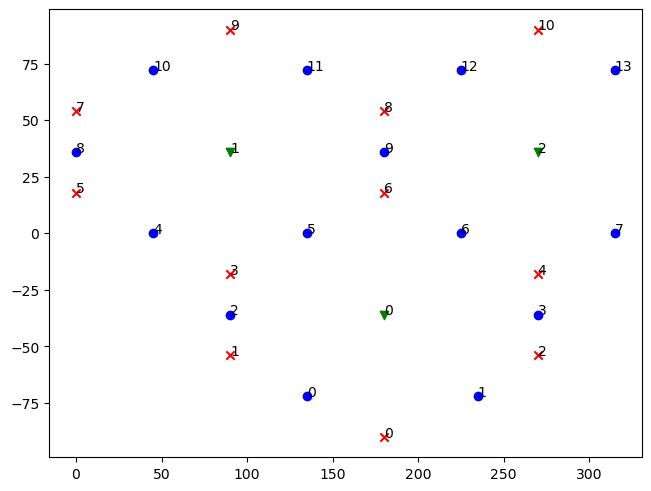

In [363]:
fig,ax=plt.subplots(nrows=1,ncols=1,constrained_layout=True)
ax.scatter(np.rad2deg(ds.lonEdge),np.rad2deg(ds.latEdge),color='blue')
ax.scatter(np.rad2deg(ds.lonVertex),np.rad2deg(ds.latVertex),marker='x',color='red')
ax.scatter(np.rad2deg(ds.lonCell), np.rad2deg(ds.latCell),marker='v',color='green')
nEdges = ds.nEdges.values
nVertices = ds.nVertices.values
nCells = ds.nCells.values

for i, txt in enumerate(nEdges):
    ax.annotate(txt, (np.rad2deg(ds.lonEdge[i]),np.rad2deg(ds.latEdge[i])))

for i, txt in enumerate(nVertices):
    ax.annotate(txt, (np.rad2deg(ds.lonVertex[i]), np.rad2deg(ds.latVertex[i])))

for i, txt in enumerate(nCells):
    ax.annotate(txt, (np.rad2deg(ds.lonCell[i]), np.rad2deg(ds.latCell[i])))

### test mask-creating function ```test_transect_from_alg_create_nc```

In [375]:
def test_transect_from_alg_create_nc(ds):
    from mpasregions.sections import transect_from_alg_create_nc
    
    # test basic algorithm
    test_vertices = np.array([3, 5, 7, 9, 8, 6])
    path = './'
    filename = 'test_basic_alg'
    geojson_file_name = 'basic test if transect_from_alg_create_nc works'
    tags = 'unstructured_hexagonal_grid;test_basic'
    author = 'Kaila Uyeda'
    geojson_vertexLats, geojson_vertexLons, dsMasks = transect_from_alg_create_nc(test_vertices, ds, path, filename, geojson_file_name, tags, author)
    assert(geojson_vertexLats == np.array([-18.,  18.,  54.,  90.,  54.,  18.])).all()
    assert(geojson_vertexLons == np.array([ 90.,   0.,   0.,  90., 180., 180.])).all()
           
    # test transects that cross over themselves
    # geojson file should maintain vertices and edges that are not connected to cells inside the desired region
    # mask that is created should only include cells inside the desired region
    test_vertices = np.array([9, 8, 6, 4, 6, 3, 5, 7])
    path = './'
    filename = 'test_crossing_transect'
    geojson_file_name = 'test if geojson file keeps vertices from transect'
    tags = 'unstructured_hexagonal_grid;test_crossing_transect'
    author = 'Kaila Uyeda'
    geojson_vertexLats, geojson_vertexLons, dsMasks = transect_from_alg_create_nc(test_vertices, ds, path, filename, geojson_file_name, tags, author)
    assert(geojson_vertexLats == np.array([ 90.,  54.,  18., -18.,  18., -18.,  18.,  54.])).all()
    assert(geojson_vertexLons == np.array([ 90., 180., 180., 270., 180.,  90.,   0.,   0.])).all()
    assert(dsMasks.isel(nRegions=0).regionCellMasks.values == np.array([0,1,0])).all()


In [442]:
test_transect_from_alg_create_nc(ds)

test_basic_alg_transect_from_alg.geojson exists!
Opening test_basic_alg_transect_from_alg.nc as dsMasks
test_crossing_transect_transect_from_alg.geojson exists!
Opening test_crossing_transect_transect_from_alg.nc as dsMasks


### test ```find_transect_edges_and_vertices``` function

In [376]:
def test_find_transect_edges_and_vertices(ds):
    from mpasregions.sections import find_transect_edges_and_vertices

    # test basic algorithm around a single cell
    # should return edges and vertices that surround that cell
    regionCellMasks_array = np.int32(np.array([[0],[1],[0]]))
    ds_mask = xr.Dataset(
        data_vars = dict(
            regionCellMasks=(['nCells','nRegions'],regionCellMasks_array),
            regionNames =(['nRegions'], np.array([b'test from transect algorithm'], dtype='|S64'))
    )) 
    xr_mask_transect_edges, xr_mask_transect_vertices = find_transect_edges_and_vertices(ds, ds_mask)
    assert(xr_mask_transect_edges == np.array([ 4,  5,  8,  9, 10, 11])).all()
    assert(xr_mask_transect_vertices == np.array([3, 5, 6, 7, 8, 9])).all()

    # test basic algorithm around multiple cells
    # edge between the two cells should not be included
    regionCellMasks_array = np.int32(np.array([[1],[1],[0]]))
    ds_mask = xr.Dataset(
        data_vars = dict(
            regionCellMasks=(['nCells','nRegions'],regionCellMasks_array),
            regionNames =(['nRegions'], np.array([b'test from transect algorithm'], dtype='|S64'))
    ))
    xr_mask_transect_edges, xr_mask_transect_vertices = find_transect_edges_and_vertices(ds, ds_mask)
    assert(xr_mask_transect_edges == np.array([ 0,  1,  2,  3,  4,  6,  8,  9, 10, 11])).all()
    assert(xr_mask_transect_vertices == np.array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])).all()

    # test basic algorithm that requires crossing a periodic boundary (cells on either side of the boundary are included in the mask)
    # edge between the two cells that border the boundary (0/360) should not be included
    regionCellMasks_array = np.int32(np.array([[0],[1],[1]]))
    ds_mask = xr.Dataset(
        data_vars = dict(
            regionCellMasks=(['nCells','nRegions'],regionCellMasks_array),
            regionNames =(['nRegions'], np.array([b'test from transect algorithm'], dtype='|S64'))
    ))
    xr_mask_transect_edges, xr_mask_transect_vertices = find_transect_edges_and_vertices(ds, ds_mask)
    assert(xr_mask_transect_edges == np.array([ 4,  5,  6,  7, 10, 11, 12, 13])).all()
    assert(xr_mask_transect_vertices == np.array([ 3,  4,  5,  6,  7,  8,  9, 10])).all()

In [441]:
test_find_transect_edges_and_vertices(ds)

### test ```sorted_transect_edges_and_vertices``` function

In [443]:
def test_sorted_transect_edges_and_vertices(ds):
    from mpasregions.sections import sorted_transect_edges_and_vertices
    # test basic algorithm (vertices and edges around a single cell)
    xr_mask_transect_edges = np.array([ 4,  5,  8,  9, 10, 11])
    xr_mask_transect_vertices = np.array([3, 5, 6, 7, 8, 9])
    sorted_edges, sorted_vertices = sorted_transect_edges_and_vertices(ds, xr_mask_transect_edges, xr_mask_transect_vertices)
    assert(sorted_edges == np.array([ 4,  5,  9, 11, 10,  8])).all()
    assert(sorted_vertices == np.array([3, 6, 8, 9, 7, 5])).all()
    
    # test basic algorithm aroudn 2 cells
    xr_mask_transect_edges = np.array([ 0,  1,  2,  3,  4,  6,  8,  9, 10, 11])
    xr_mask_transect_vertices = np.array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])
    sorted_edges, sorted_vertices = sorted_transect_edges_and_vertices(ds, xr_mask_transect_edges, xr_mask_transect_vertices)
    assert(sorted_edges == np.array([ 0,  1,  3,  6,  9, 11, 10,  8,  4,  2])).all()
    assert(sorted_vertices == np.array([0, 2, 4, 6, 8, 9, 7, 5, 3, 1])).all()
    
    # test algorithm for mask bounded with complete lines of latitude
    # should have a broken transect that "switches" from the lower boundary to the upper boundary
    xr_mask_transect_edges = np.array([ 4,  5,  6,  7, 10, 11, 12, 13])
    xr_mask_transect_vertices = np.array([ 3,  4,  5,  6,  7,  8,  9, 10])
    sorted_edges, sorted_vertices = sorted_transect_edges_and_vertices(ds, xr_mask_transect_edges, xr_mask_transect_vertices)
    assert(sorted_edges == np.array([ 4,  5,  6,  7, 10, 13, 12, 11])).all()
    assert(sorted_vertices == np.array([ 3,  6,  4,  5,  7, 10,  8,  9])).all()

In [453]:
test_sorted_transect_edges_and_vertices(ds)

switching transects at  4


### test combined find and sort functions ```find_and_sort_transect_edges_and_vertices```

In [456]:
def test_find_and_sort_transect_edges_and_vertices(ds):
    from mpasregions.sections import find_and_sort_transect_edges_and_vertices
    # test basic algorithm 
    # mask around a single cell
    regionCellMasks_array = np.int32(np.array([[0],[1],[0]]))
    ds_mask = xr.Dataset(
            data_vars = dict(
                regionCellMasks=(['nCells','nRegions'],regionCellMasks_array),
                regionNames =(['nRegions'], np.array([b'test from transect algorithm'], dtype='|S64'))
        ))
    next_edges, next_vertices = find_and_sort_transect_edges_and_vertices(ds, ds_mask)
    assert(next_edges == np.array([ 4,  5,  9, 11, 10,  8])).all()
    assert(next_vertices == np.array([3, 6, 8, 9, 7, 5])).all()

    # test basic algorithm
    # mask around two cells
    regionCellMasks_array = np.int32(np.array([[1],[1],[0]]))
    ds_mask = xr.Dataset(
        data_vars = dict(
            regionCellMasks=(['nCells','nRegions'],regionCellMasks_array),
            regionNames =(['nRegions'], np.array([b'test from transect algorithm'], dtype='|S64'))
    ))
    next_edges, next_vertices = find_and_sort_transect_edges_and_vertices(ds, ds_mask)
    assert(next_edges == np.array([ 0,  1,  3,  6,  9, 11, 10,  8,  4,  2])).all()
    assert(next_vertices == np.array([0, 2, 4, 6, 8, 9, 7, 5, 3, 1])).all()

    # test algorithm for mask bounded with complete lines of latitude
    # should have a broken transect that "switchees from the lower boundary to the upper boundary
    regionCellMasks_array = np.int32(np.array([[0],[1],[1]]))
    ds_mask = xr.Dataset(
        data_vars = dict(
            regionCellMasks=(['nCells','nRegions'],regionCellMasks_array),
            regionNames =(['nRegions'], np.array([b'test from transect algorithm'], dtype='|S64'))
    ))
    next_edges, next_vertices = find_and_sort_transect_edges_and_vertices(ds, ds_mask)
    assert(next_edges == np.array([ 4,  5,  6,  7, 10, 13, 12, 11])).all()
    assert(next_vertices == np.array([ 3,  6,  4,  5,  7, 10,  8,  9])).all()

In [457]:
test_find_and_sort_transect_edges_and_vertices(ds)

switching transects at  4
